In [1]:
import numpy as np
import pandas as pd
import os
import random
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, GlobalAveragePooling2D, Flatten, Dropout, Input, Conv2DTranspose, Activation, Add, DepthwiseConv2D, concatenate
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 14

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2Dfrom tensorflow import keras

input_shape = (28, 28, 1)  # Example for a 28x28 grayscale image

model = keras.Sequential([
    keras.Input(shape=input_shape),
    # ... your other layers ...
])

SyntaxError: invalid syntax (<ipython-input-2-675ebb09f5e4>, line 3)

In [3]:
!kaggle datasets download -d kmader/satellite-images-of-hurricane-damage


Dataset URL: https://www.kaggle.com/datasets/kmader/satellite-images-of-hurricane-damage
License(s): Attribution 4.0 International (CC BY 4.0)
100% 63.0M/63.0M [00:04<00:00, 22.9MB/s]
100% 63.0M/63.0M [00:04<00:00, 16.0MB/s]


In [4]:
batch_size = 32
img_size = 224
train1_directory = '/content//train_another'
validation_directory = '/content/validation_another'
test_directory = '/content/test'
train2_directory = '/content/test_another'


In [5]:
!unzip satellite-images-of-hurricane-damage.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/train_another/no_damage/-95.627453_29.859303000000004.jpeg  
  inflating: /content/train_another/no_damage/-95.62745600000001_29.777524.jpeg  
  inflating: /content/train_another/no_damage/-95.627485_29.777865999999996.jpeg  
  inflating: /content/train_another/no_damage/-95.62751800000001_29.857785999999997.jpeg  
  inflating: /content/train_another/no_damage/-95.62751999999999_29.860796999999998.jpeg  
  inflating: /content/train_another/no_damage/-95.627523_29.770004999999998.jpeg  
  inflating: /content/train_another/no_damage/-95.62753000000001_29.863289.jpeg  
  inflating: /content/train_another/no_damage/-95.627539_29.827047999999998.jpeg  
  inflating: /content/train_another/no_damage/-95.627543_29.860021000000003.jpeg  
  inflating: /content/train_another/no_damage/-95.627563_29.8628.jpeg  
  inflating: /content/train_another/no_damage/-95.627579_29.864051.jpeg  
  inflating: /content/train_another/no_dam

In [6]:
!ls /content/satellite-images-of-hurricane-damage/


ls: cannot access '/content/satellite-images-of-hurricane-damage/': No such file or directory


In [7]:
batch_size = 32
img_size = 224

In [8]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  rotation_range=30,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range = 0.1)

validation_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)

train1_generator = train_datagen.flow_from_directory(train1_directory,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='binary')


Found 10000 images belonging to 2 classes.


In [9]:
validation_generator = validation_datagen.flow_from_directory(validation_directory,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_directory,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [10]:
train2_generator = train_datagen.flow_from_directory(
    train2_directory,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
)

Found 9000 images belonging to 2 classes.


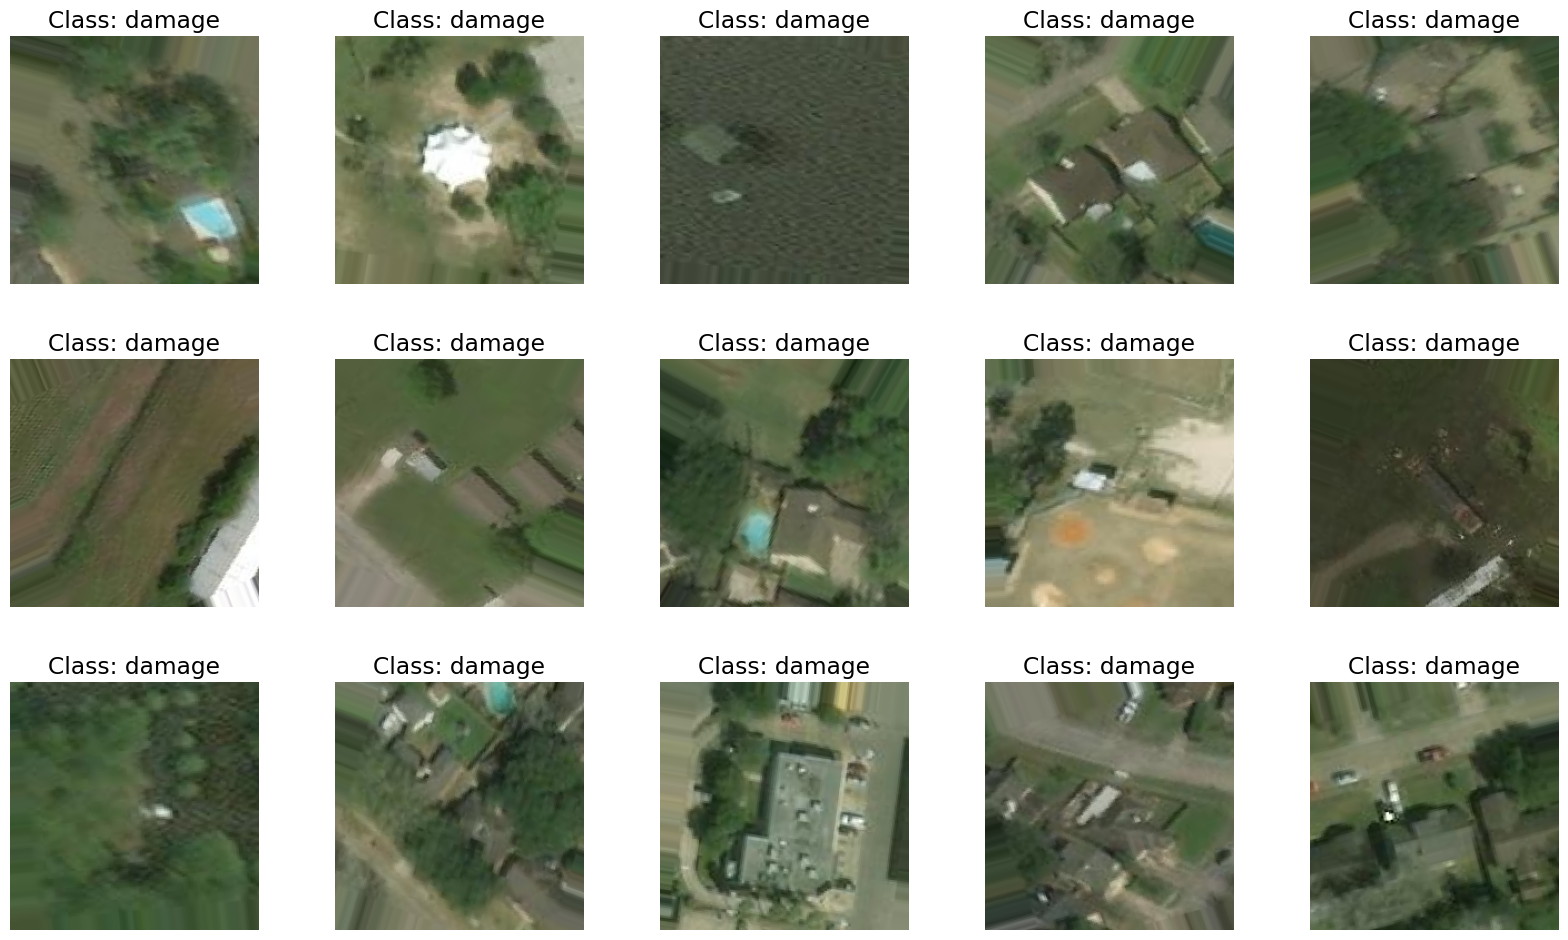

In [11]:
labels = [k for k in train1_generator.class_indices]
sample_generate = train1_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))



for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [12]:
import os
import pandas as pd

# Directories
folders = [train1_directory, train2_directory, validation_directory]

# Create an empty DataFrame with the desired columns
df_mapping = pd.DataFrame(columns=['longitude', 'latitude', 'class'])

# Loop through folders and extract data from filenames
for folder_path in folders:
    for class_folder in os.listdir(folder_path):
        if not os.path.isdir(os.path.join(folder_path, class_folder)):
            continue

        for filename in os.listdir(os.path.join(folder_path, class_folder)):
            if filename.endswith('.jpeg'):
                lon, lat = filename.split('_')[0], filename.split('_')[1]
                lat = lat.rstrip('.jpeg')
                img_class = class_folder

                # Create a temporary DataFrame with the new row
                new_row = pd.DataFrame({'longitude': [lon], 'latitude': [lat], 'class': [img_class]})

                # Concatenate the new row with the existing DataFrame
                df_mapping = pd.concat([df_mapping, new_row], ignore_index=True)

# Display the final DataFrame
df_mapping


longitude            latitude      class
0              -95.626584           29.776663  no_damage
1              -95.246262           30.029911  no_damage
2              -95.161244           30.026595  no_damage
3              -95.084336  29.796703000000004  no_damage
4      -95.65070300000001  29.832736999999998  no_damage
...                   ...                 ...        ...
20995          -93.811854  30.036596000000003     damage
20996          -95.566787           29.757049     damage
20997  -95.15978199999999  29.928490000000004     damage
20998  -96.90487900000001  28.783659000000004     damage
20999          -95.632848           29.851626     damage

[21000 rows x 3 columns]

In [13]:
#pooling
base_model = Xception(include_top = False,
                      weights = 'imagenet',
                      input_shape = (img_size, img_size, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [14]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [15]:
len(base_model.layers)

132

In [16]:
for layer in base_model.layers[:-len(base_model.layers)//4]:
    layer.trainable = False
# base_model.trainable = False

In [17]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 9,478,344 (36.16 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

In [18]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # to prevent overfitting
model.add(Dense(1, activation='sigmoid'))

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16  # Example pre-trained base model

# Example pre-trained base model
base_model = VGG16(include_top=False, input_shape=(None, None, 3))  # Flexible height and width, with 3 channels

model = Sequential()

# Input layer with flexible shape for height and width (but fixed 3 channels for RGB)
model.add(Input(shape=(None, None, 3)))

# Add the base model
model.add(base_model)

# Use GlobalAveragePooling2D instead of Flatten for flexible input shape
model.add(GlobalAveragePooling2D())

# Add Dense and Dropout layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Add final output layer
model.add(Dense(1, activation='sigmoid'))

# Print model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, None, None, 512)     │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 14,977,857 (57.14 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Use .keras extension instead of .h5
model_name = 'model1.keras'

# Corrected 'monitor' argument and file extension
checkpoint = ModelCheckpoint(model_name,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1,
                              restore_best_weights=True)


In [22]:
history = model.fit(train1_generator,
                   epochs=50,
                   validation_data=validation_generator,
                   callbacks=[checkpoint,earlyStopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8432 - loss: 0.3412
Epoch 1: val_loss improved from inf to 0.18383, saving model to model1.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 271s 736ms/step - accuracy: 0.8434 - loss: 0.3409 - val_accuracy: 0.9355 - val_loss: 0.1838
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9278 - loss: 0.1866
Epoch 2: val_loss improved from 0.18383 to 0.11438, saving model to model1.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 191s 601ms/step - accuracy: 0.9278 - loss: 0.1865 - val_accuracy: 0.9635 - val_loss: 0.1144
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9561 - loss: 0.1116
Epoch 3: val_loss did not improve from 0.11438
313/313 ━━━━━━━━━━━━━━━━━━━━ 186s 586ms/step - accuracy: 0.9561 - loss: 0.1116 - val_accuracy: 0.9550 - val_loss: 0.1290
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9701 - loss: 0.0853
Epoch 4: val_loss improved from 0.11438 to 0.09279, saving model to model1.keras
313/313 ━━

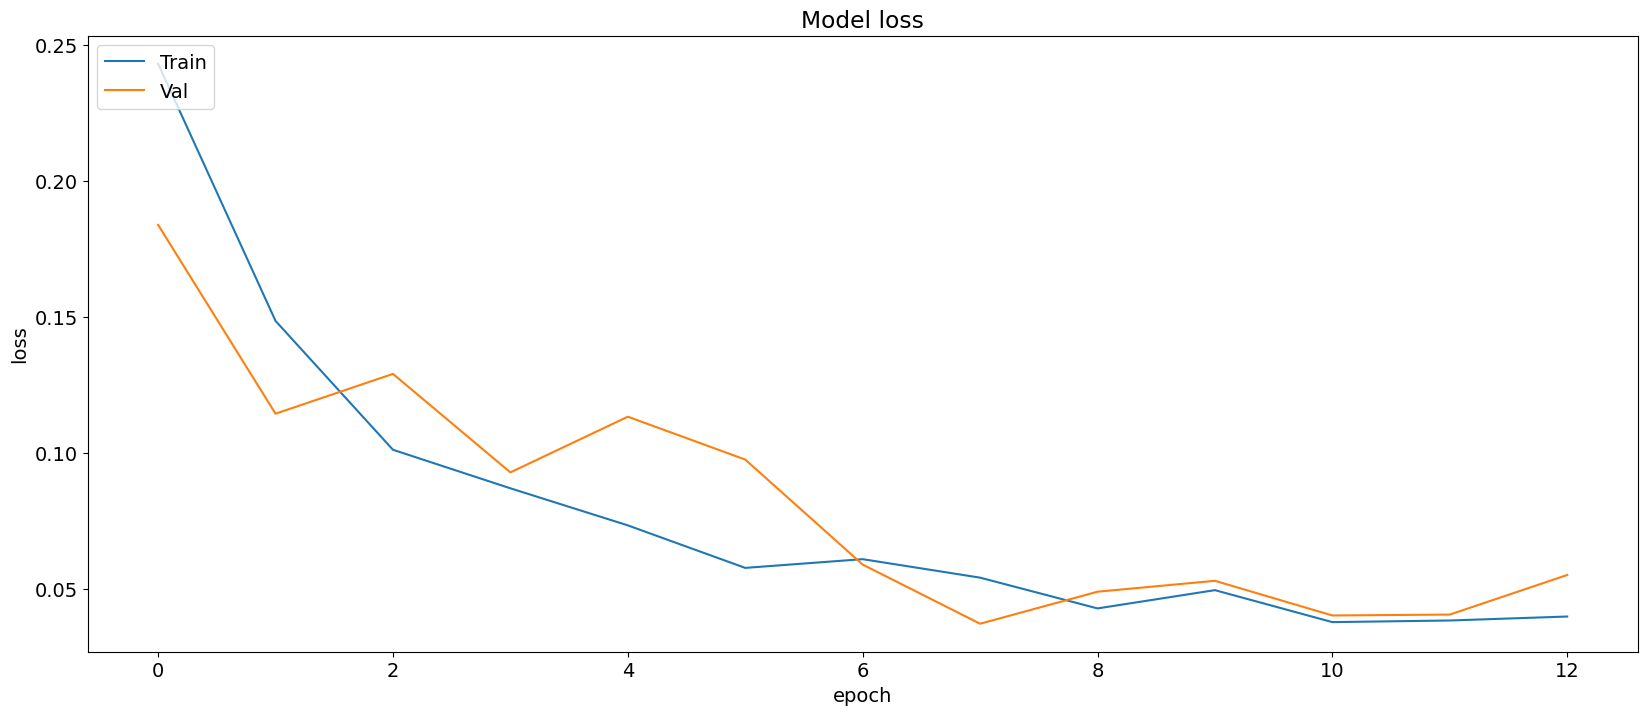

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Val'], loc='upper left')
plt.show()

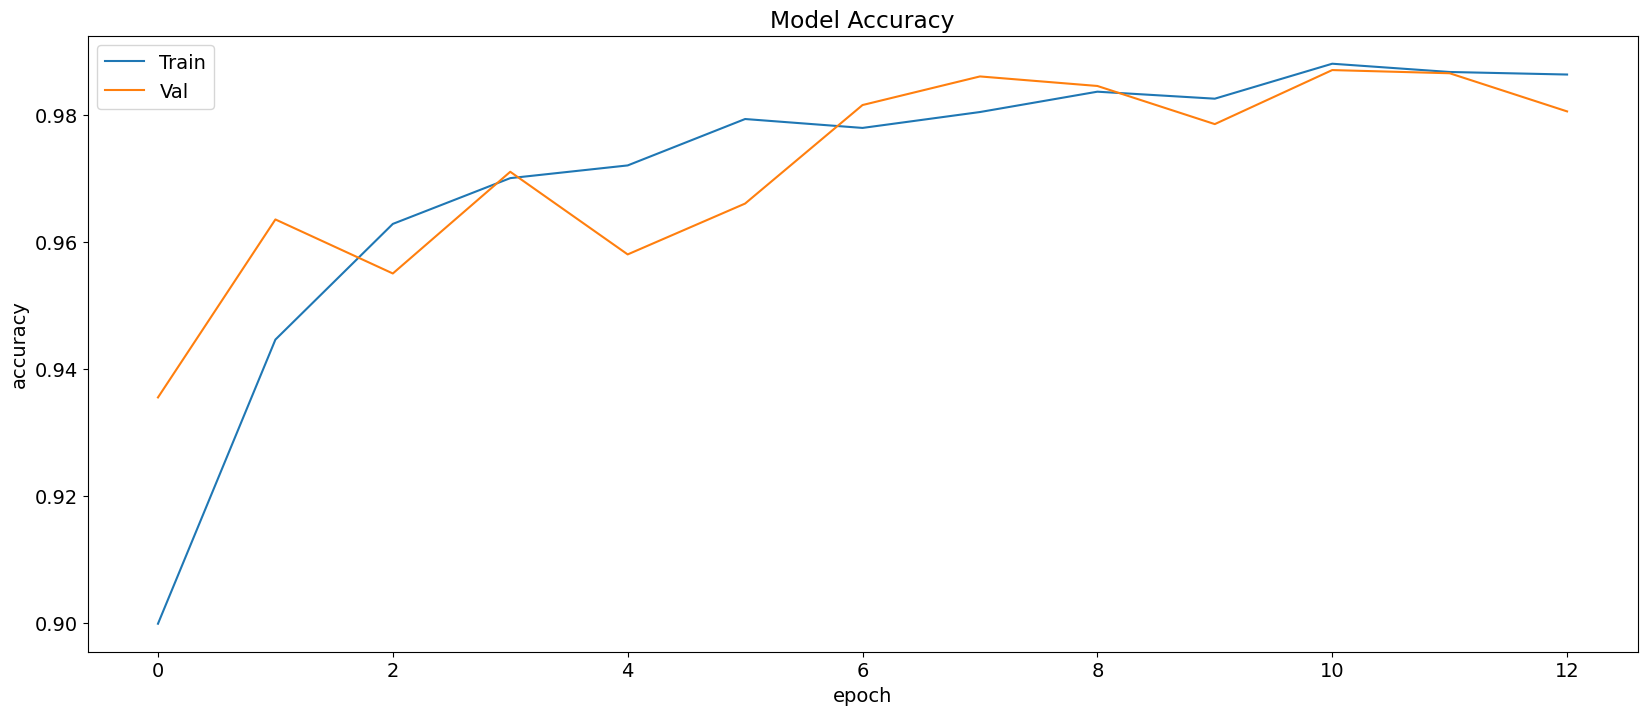

In [24]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [25]:
model.evaluate(test_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9903 - loss: 0.0218


[0.0283068660646677, 0.987500011920929]

In [26]:
model.save(model_name)

In [32]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [40]:
# Save the model to a specific path
model.save('/content/model1.keras')


In [47]:
import os
import pandas as pd

# Create an empty DataFrame with 'longitude' and 'latitude' columns
df_mapping = pd.DataFrame(columns=['longitude', 'latitude'])
folder_path = test_directory  # Ensure this is the correct path to your test directory

# Prepare a list to collect the data first
data = []

for class_folder in os.listdir(folder_path):
    if not os.path.isdir(os.path.join(folder_path, class_folder)):
        continue

    for filename in os.listdir(os.path.join(folder_path, class_folder)):
        if filename.endswith('.jpeg'):
            lon, lat = filename.split('_')[0], filename.split('_')[1]
            lat = lat.rstrip('.jpeg')
            data.append({'longitude': lon, 'latitude': lat})

# Use pd.concat instead of append
df_mapping = pd.concat([df_mapping, pd.DataFrame(data)], ignore_index=True)

# Show the DataFrame
df_mapping


longitude            latitude
0             -95.652001  29.832341999999997
1             -95.641205  29.836384999999996
2             -95.632936           29.846957
3             -96.997946           28.814549
4             -95.269853           29.604366
...                  ...                 ...
1995  -95.63838100000001           29.837928
1996          -95.306459           29.594694
1997          -95.642484  29.771559000000003
1998  -95.15978199999999  29.928490000000004
1999          -95.631632  29.850489000000003

[2000 rows x 2 columns]

In [48]:
classes = ['damage','no_damage']
predictions = model.predict(test_generator)
df_mapping['predicted'] = np.where(predictions>0.5, classes[1], classes[0])
df_mapping

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step


longitude            latitude  predicted
0             -95.652001  29.832341999999997     damage
1             -95.641205  29.836384999999996     damage
2             -95.632936           29.846957     damage
3             -96.997946           28.814549     damage
4             -95.269853           29.604366     damage
...                  ...                 ...        ...
1995  -95.63838100000001           29.837928  no_damage
1996          -95.306459           29.594694  no_damage
1997          -95.642484  29.771559000000003  no_damage
1998  -95.15978199999999  29.928490000000004  no_damage
1999          -95.631632  29.850489000000003  no_damage

[2000 rows x 3 columns]

In [49]:
import folium

df_mapping['latitude'] = df_mapping['latitude'].astype(float)
df_mapping['longitude'] = df_mapping['longitude'].astype(float)

map_center = [df_mapping['latitude'].mean(), df_mapping['longitude'].mean()]
map_obj = folium.Map(location=map_center, zoom_start=10)

for index, row in df_mapping.iterrows():
    color = 'red' if row['predicted'] == 'damage' else 'green'

    marker = folium.Marker(location=[row['latitude'], row['longitude']], icon=folium.Icon(color=color))
    marker.add_to(map_obj)

map_obj